# Machine Learning Workflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Use of pipelines

In [2]:
# First upload the data via 'Upload Files'
housing = pd.read_csv("ca_housing_data.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


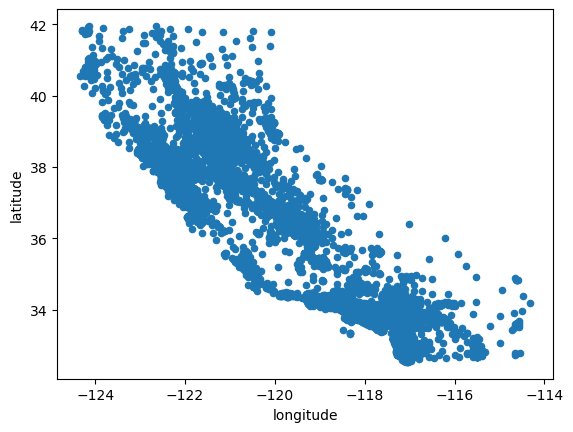

In [3]:
housing.plot(kind="scatter", x="longitude", y="latitude");

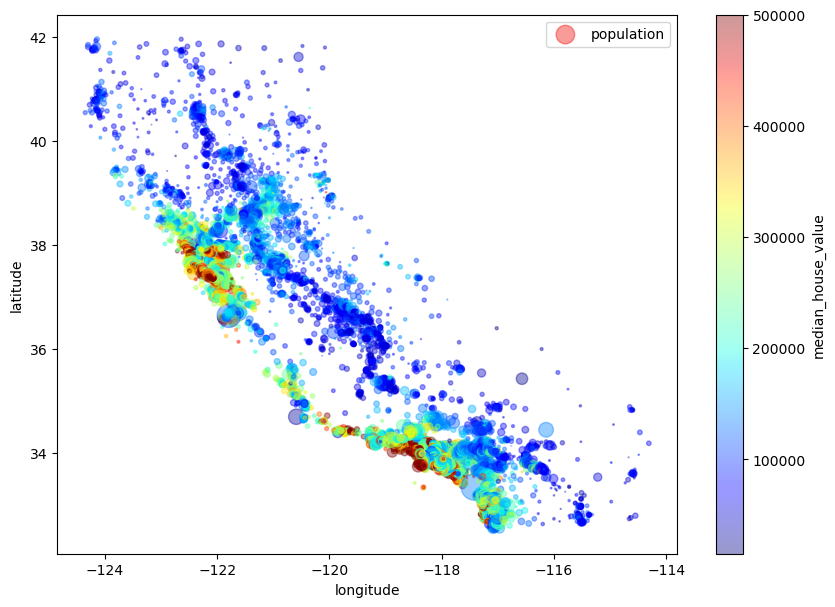

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend();

In [5]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY


In [6]:
# define your own transformation
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, 
                                 validate=False, 
                                 kw_args={"add_bedrooms_per_room": False})

In [7]:
# put everything in one pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', attr_adder),
    ('std_scaler', StandardScaler())],) 

housing_labels = housing['median_house_value']
housing = housing.drop('median_house_value', axis = 1)

# get the numerical columns
housing_num = housing.drop('ocean_proximity', axis=1)

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [8]:
housing_num_tr[sample_incomplete_rows.index,:]
# we can see that Nan values have been imputed, features have been added, values are normalized

array([[-1.29289607,  1.00104776,  1.45889113, -0.63246556, -0.24283094,
        -0.75543142, -0.73639705,  0.26546765,  0.13437871, -0.04390383],
       [-1.29788738,  0.99168403,  0.74376842, -0.75347974, -0.24283094,
        -0.61237681, -0.62915718, -1.1849141 , -0.64624525, -0.02353217],
       [-1.35279176,  1.00572963,  0.02864572,  1.15432725, -0.24283094,
         2.04473007,  2.02306792, -0.68138097, -0.55789521, -0.01270271],
       [-1.33282653,  0.99168403,  1.29997497, -0.79977684, -0.24283094,
        -0.9196793 , -0.92472072,  0.56755595,  0.27231575, -0.04241544],
       [-1.26294823,  0.96359283,  0.98214266, -0.86624296, -0.24283094,
        -0.91703014, -0.88548662,  0.01875432, -0.32151292, -0.06421543]])

In [9]:
# full pipeline for numerical and categorical features
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [10]:
# --->>> Your turn <<<---
# build a full pipeline that takes care of the numerical and categorical feature
# hint: use ColumnTransformer,
# use OneHotEncoder to process the categorical feature

In [11]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [12]:
pd.DataFrame(housing_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.628559,-0.049597,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.327041,-0.092512,0.0,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.155620,-0.025843,0.0,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.156966,-0.050329,0.0,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.344711,-0.085616,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.444985,-0.388283,-0.512592,-0.443449,-1.216128,-0.155023,-0.049110,0.0,1.0,0.0,0.0,0.0
20636,-0.818722,1.806329,-0.845393,-0.888704,-0.922403,-0.944405,-1.008420,-0.691593,0.276881,0.005021,0.0,1.0,0.0,0.0,0.0
20637,-0.823713,1.778237,-0.924851,-0.174995,-0.123608,-0.369537,-0.174042,-1.142593,-0.090318,-0.071735,0.0,1.0,0.0,0.0,0.0
20638,-0.873626,1.778237,-0.845393,-0.355600,-0.304827,-0.604429,-0.393753,-1.054583,-0.040211,-0.091225,0.0,1.0,0.0,0.0,0.0


In [13]:
# hint: predict house values and check how far from the real value the predicted values are

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [14]:
n_samples = 5
samples = housing.iloc[:n_samples]
lables = housing_labels.iloc[:n_samples]
predictions = lin_reg.predict(full_pipeline.transform(samples))
off = 1 - (predictions/list(lables))
off *= 100

for i in range(n_samples):
    print(f"The true house value is {lables[i]:.0f}, prediction is {predictions[i]:.0f}, off by {-off[i]:5.1f}%")

The true house value is 452600, prediction is 408104, off by  -9.8%
The true house value is 358500, prediction is 423228, off by  18.1%
The true house value is 352100, prediction is 381039, off by   8.2%
The true house value is 341300, prediction is 320590, off by  -6.1%
The true house value is 342200, prediction is 257288, off by -24.8%


# A modeling example

### Prediction of Diabetes dataset with Decision Trees

In [25]:
print(datasets.load_diabetes()['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [26]:
X0, y0 = datasets.load_diabetes(return_X_y=True)

# we use the first 300 samples as training data
X_train = X0[:300]
y_train = y0[:300]
# and thre rest as test data
X_test = X0[300:]
y_test = y0[300:]

# convert it into a classification problem
threshold = np.mean(y_train)
y_train = (y_train > threshold).astype(int)
y_test = (y0[300:] > threshold).astype(int)  

In [27]:
# --->>> Your Turn <<<---
# why do we calculate the threshold only on the training data?

# the threshold is calculated only on the training data to avoid data leakage.
# If we were to calculate the threshold using the entire dataset (including the test set),
# it would introduce information from the test set into the training process.

In [28]:
# Regression model with decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

# Fit the model
model = DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=10)
model.fit(X_train, y_train)

# Prediction on training data
y_pred = model.predict(X_train)
accuracy_score(y_train,y_pred)

0.7533333333333333

In [29]:
# --->>> Your Turn <<<---
# Try to adjust the hyperparameters:  
# What is the best performance you can get?

In [31]:
model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train,y_pred)

1.0

In [ ]:
# --->>> Your Turn <<<---
# Now test your final model on the test dataset
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

#it looks like we are overfitting the training data quite a bit

0.647887323943662

In [ ]:
# --->>> Your Turn <<<---
# using train, validation, test dataset with train_test_split
# and tune the hyperparameters on the validation dataset and 
# only in the end test it on the test dataset

In [ ]:
#using train, validation, test dataset with train_test_split
X0, y0 = datasets.load_diabetes(return_X_y=True) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

# convert it into a classification problem
threshold = np.mean(y_train)
y_train = (y_train > threshold).astype(int)
y_test = (y_test > threshold).astype(int)
y_val = (y_val > threshold).astype(int)

print(X_train.shape, X_val.shape, X_test.shape)

(264, 10) (89, 10) (89, 10)


In [33]:
# initial model
model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy_score(y_val,y_pred)

0.9325842696629213

In [34]:
# tune hyperparameters
model = DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy_score(y_val,y_pred)

0.7752808988764045

In [35]:
# evaluate on test dataset
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7183098591549296